In [1]:
import torch
import yahpo_gym
import botorch
import ax
import ConfigSpace

# Testing and setup

In [7]:
from yahpo_gym import local_config
local_config.init_config()
local_config.set_data_path('~/Documents/yahpo_data')

In [3]:
benchmark = yahpo_gym.BenchmarkSet('lcbench')
benchmark.instances[:5]

['3945', '7593', '34539', '126025', '126026']

In [4]:
benchmark = yahpo_gym.BenchmarkSet('lcbench', instance='126025')

# Basic hyperparameter tuning example

In [5]:
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.datasets import SupervisedDataset
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP


class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, kernel='rbf'):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        if kernel == 'rbf':
            self.covar_module = ScaleKernel(
                base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
            )
        elif kernel == 'matern':
            self.covar_module = ScaleKernel(
                base_kernel=MaternKernel(ard_num_dims=train_X.shape[-1]),
            )
        else:
            ValueError('No such kernel')
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [6]:
benchmark.get_fidelity_space()

Configuration space object:
  Hyperparameters:
    epoch, Type: UniformInteger, Range: [1, 50], Default: 26

In [7]:
import json

hyperparams = benchmark.get_opt_space()
hyperparams_list = json.loads(ConfigSpace.read_and_write.json.write(hyperparams))['hyperparameters']
hyperparams_list

def format_hyperparam(h):
    try:
        log_scale = h.pop('log')
        h['log_scale'] = log_scale
    except KeyError:
        pass
    
    try:
        lower = h.pop('lower')
        upper = h.pop('upper')
        h['bounds'] = [lower, upper]
    except KeyError:
        pass
    
    try:
        choices = h.pop('choices')
        h['values'] = choices
    except KeyError:
        pass
    
    try:
        h.pop('default')
    except KeyError:
        pass
    
    try:
        h.pop('weights')
    except KeyError:
        pass
    
    type_map = {
        'uniform_int':'range',
        'categorical':'choice',
        'uniform_float':'range',
        'constant':'fixed',
        'ordinal':'range'
    }
    value_map = {
        'uniform_int':'int',
        'uniform_float':'float',
        'ordinal':'int'
    }
    h['type'] = type_map[h['type']]
    
    return h

hyperparams_list = [format_hyperparam(h) for h in hyperparams_list]
hyperparams_list[2] = {'name': 'epoch', 'type': 'fixed', 'value': 40}
hyperparams_list

[{'name': 'OpenML_task_id', 'type': 'fixed', 'value': '126025'},
 {'name': 'batch_size',
  'type': 'range',
  'log_scale': True,
  'bounds': [16, 512]},
 {'name': 'epoch', 'type': 'fixed', 'value': 40},
 {'name': 'learning_rate',
  'type': 'range',
  'log_scale': True,
  'bounds': [0.00010000000000000009, 0.10000000000000002]},
 {'name': 'max_dropout',
  'type': 'range',
  'log_scale': False,
  'bounds': [0.0, 1.0]},
 {'name': 'max_units',
  'type': 'range',
  'log_scale': True,
  'bounds': [64, 1024]},
 {'name': 'momentum',
  'type': 'range',
  'log_scale': False,
  'bounds': [0.1, 0.99]},
 {'name': 'num_layers', 'type': 'range', 'log_scale': False, 'bounds': [1, 5]},
 {'name': 'weight_decay',
  'type': 'range',
  'log_scale': False,
  'bounds': [1e-05, 0.1]}]

In [8]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition import qExpectedImprovement, qMaxValueEntropy, qKnowledgeGradient


In [13]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs_ei_rbf = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=30,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
                "botorch_acqf_class":qExpectedImprovement
            },
        ),
    ]
)

gs_es_rbf = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=30,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
                "botorch_acqf_class":qMaxValueEntropy
            },
        ),
    ]
)
gs_es_mat = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=30,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP, model_options={"kernel":'matern'}),
                "botorch_acqf_class":qMaxValueEntropy
            },
        ),
    ]
)

gs_ei_mat = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=50,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP, model_options={"kernel":'matern'}),
                "botorch_acqf_class":qExpectedImprovement
            },
        ),
    ]
)

In [14]:

import torch
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import Branin
from ax.utils.notebook.plotting import render

# Setup a function to evaluate the trials
objective = benchmark.objective_function


def evaluate(parameters):
    # The GaussianLikelihood used by our model infers an observation noise level,
    # so we pass an sem value of NaN to indicate that observation noise is unknown
    return {"accuracy": (objective(parameters)[0]['val_accuracy'], float("nan"))}

# Mutiple experiments for different BO setups
traces = {}
for name, generation_strategy in [('ei_mat', gs_ei_mat), 
                                  ('ei_rbf', gs_ei_rbf), 
                                  ('es_mat', gs_es_mat), 
                                  ('es_rbf', gs_es_rbf)]:
    
    # Initialize the client - AxClient offers a convenient API to control the experiment
    ax_client = AxClient(generation_strategy=generation_strategy, verbose_logging=False)
    
    # Setup the experiment
    ax_client.create_experiment(
        name="yahpo_test_experiment",
        parameters=hyperparams_list,
        objectives={
            "accuracy": ObjectiveProperties(minimize=False),
        },
    )
    NUM_EVALS = 150
    for i in range(NUM_EVALS):
        try:
            parameters, trial_index = ax_client.get_next_trial()
            # Local evaluation here can be replaced with deployment to external system.
            ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))
        except Exception:
            break
        

        
    max_accuracy = benchmark.target_stats[benchmark.target_stats.metric == 'val_accuracy']['value'].values[1]
    render(ax_client.get_optimization_trace(objective_optimum=max_accuracy))
    traces[name] = ax_client.get_trace(ax_client.experiment)

[INFO 12-20 14:25:06] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:25:06] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:25:06] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter max_dropout. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:25:06] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_units. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') 

[INFO 12-20 14:25:24] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:25:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:25:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter max_dropout. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:25:24] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_units. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') 

[INFO 12-20 14:28:54] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:28:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:28:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter max_dropout. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:28:54] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_units. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') 

[INFO 12-20 14:36:59] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:36:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:36:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter max_dropout. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-20 14:36:59] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_units. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') 

<AxesSubplot:>

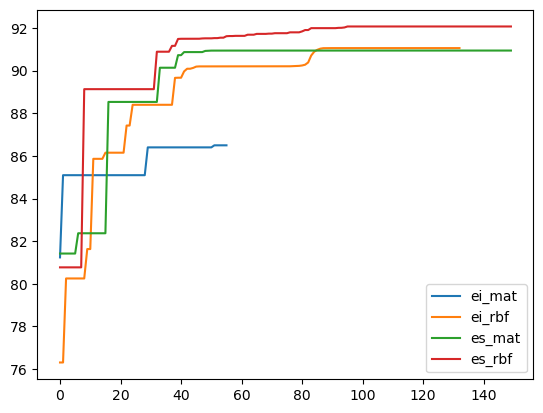

In [19]:
import pandas as pd
pd.DataFrame.from_dict(traces, orient="index").T.plot()

# Testing the FABOLAS algorithm from EmuKit

In [2]:
import emukit
from emukit.examples.fabolas import fmin_fabolas
from emukit.core import ContinuousParameter, ParameterSpace

import ConfigSpace
import logging
logging.basicConfig(level=logging.DEBUG)

In [3]:
benchmark = yahpo_gym.BenchmarkSet('rbv2_super')
benchmark = yahpo_gym.BenchmarkSet('rbv2_super', instance=benchmark.instances[0])
default_config = benchmark.config_space.get_default_configuration()
default_config["learner_id"] = "xgboost"
svm_hyperparameters = benchmark.config_space.get_active_hyperparameters(default_config)

l = []
for param_name in svm_hyperparameters:
    # handle fidelity separately
    if param_name == "trainsize":
        continue
    
    param = benchmark.config_space.get_hyperparameter(param_name)
    if isinstance(param, ConfigSpace.hyperparameters.FloatHyperparameter):
        l.append(ContinuousParameter(param.name, param.lower, param.upper))

space = ParameterSpace(l)

# Multiplying by a large value for stability purposes (FABOLAS assumes we have actual values of s, not just ratios)
dataset_size = 1e5
s_min = benchmark.config_space.get_hyperparameter("trainsize").lower * dataset_size
s_max = benchmark.config_space.get_hyperparameter("trainsize").upper * dataset_size


def wrapper(x, s):
    for k, v in zip(space.parameter_names, x):
        default_config[k] = v
    default_config["trainsize"] = s / dataset_size
    res = benchmark.objective_function(default_config)[0]
    return -res["acc"], res["timetrain"]


res = fmin_fabolas(wrapper, space=space, s_min=s_min, s_max=s_max, n_iters=15, n_init=10, marginalize_hypers=False, acquisition_function="mes")

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


TypeError: __init__() takes from 3 to 5 positional arguments but 8 were given

## Testing vs. other hyperparameter optimization frameworks

# Trying different modeling backends

# Trying different acquisition functions

# Trying different MC optimization backends

# Trying an ensemble model backend

# Parallelizing FABOLAS